# Feature Engineering: Feature Creation

### Read in text

In [1]:


import pandas as pd
import re
import string
import nltk
pd.set_option('display.max_colwidth', 100)

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

address="C:/Users/ANTHONY/Desktop/CSV&XLSX/SMSSpamCollection.tsv"


data = pd.read_csv(address, sep='\t')
data.columns = ['label', 'body_text']

data

,label,body_text
0,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
1,ham,"Nah I don't think he goes to usf, he lives around here though"
2,ham,Even my brother is not like to speak with me. They treat me like aids patent.
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
4,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...
...,...,...
5562,spam,This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy...
5563,ham,Will ü b going to esplanade fr home?
5564,ham,"Pity, * was in mood for that. So...any other suggestions?"
5565,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week ...


### Create feature for text message length

In [10]:
data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))

data.head()

,label,body_text,punct%,body_len
0,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,4.7,128
1,ham,"Nah I don't think he goes to usf, he lives around here though",4.1,49
2,ham,Even my brother is not like to speak with me. They treat me like aids patent.,3.2,62
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,7.1,28
4,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...,4.4,135


In [11]:
data['body_text'][3]

'I HAVE A DATE ON SUNDAY WITH WILL!!'

In [12]:
len(data['body_text'][3])-data['body_text'][3].count(" ")    ###3  excluding white spaces

28

### Create feature for % of text that is punctuation

In [13]:
import string

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

data.head()

,label,body_text,punct%,body_len
0,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,4.7,128
1,ham,"Nah I don't think he goes to usf, he lives around here though",4.1,49
2,ham,Even my brother is not like to speak with me. They treat me like aids patent.,3.2,62
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,7.1,28
4,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...,4.4,135


### Evaluate created features

In [7]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline

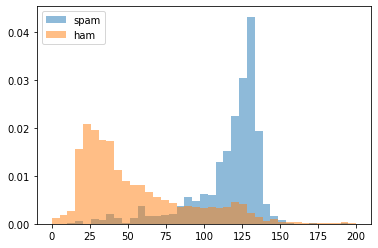

In [15]:
#######  normalized

bins = np.linspace(0, 200, 40)

pyplot.hist(data[data['label']=='spam']['body_len'], bins, alpha=0.5, density=True, label='spam')
pyplot.hist(data[data['label']=='ham']['body_len'], bins, alpha=0.5, density=True, label='ham')
pyplot.legend(loc='upper left')
pyplot.show()

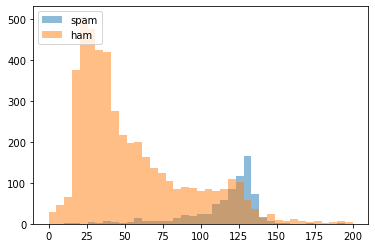

In [16]:
######## no normalizing

bins = np.linspace(0, 200, 40)

pyplot.hist(data[data['label']=='spam']['body_len'], bins, alpha=0.5,  label='spam')
pyplot.hist(data[data['label']=='ham']['body_len'], bins, alpha=0.5,  label='ham')
pyplot.legend(loc='upper left')
pyplot.show()

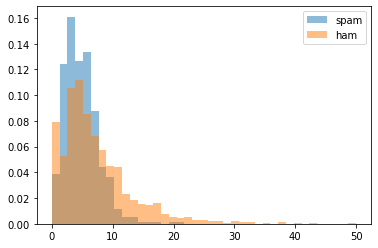

In [18]:
bins = np.linspace(0, 50, 40)

pyplot.hist(data[data['label']=='spam']['punct%'], bins, alpha=0.5, density=True, label='spam')
pyplot.hist(data[data['label']=='ham']['punct%'], bins, alpha=0.5, density=True, label='ham')
pyplot.legend(loc='upper right')
pyplot.show()

our hypothesis that spam messages tend to be longer than non-spam messages seems to be correct based on this evaluation, and this feature is likely to provide some value to the model. However, our hypothesis that ham messages contain less punctuation than spam doesn't appear to be accurate, and it isn't quite clear whether this feature will provide value to the model.

### TRANSFORMING SKEWED DISTRIBUTION

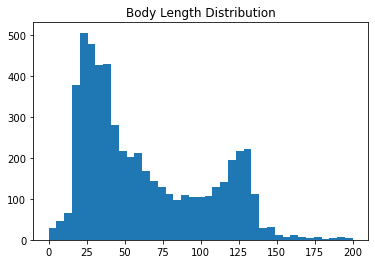

In [19]:
bins = np.linspace(0, 200, 40)

pyplot.hist(data['body_len'], bins)
pyplot.title("Body Length Distribution")
pyplot.show()                                     #####  not skewdd

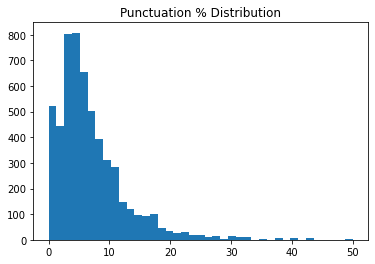

In [20]:
bins = np.linspace(0, 50, 40)

pyplot.hist(data['punct%'], bins)
pyplot.title("Punctuation % Distribution")
pyplot.show()                                  #######   highly skewed

### Box-Cox Power Transformation

**Base Form**: $$ y^x $$

| X    | Base Form           |           Transformation               |
|------|--------------------------|--------------------------|
| -2   | $$ y ^ {-2} $$           | $$ \frac{1}{y^2} $$      |
| -1   | $$ y ^ {-1} $$           | $$ \frac{1}{y} $$        |
| -0.5 | $$ y ^ {\frac{-1}{2}} $$ | $$ \frac{1}{\sqrt{y}} $$ |
| 0    | $$ y^{0} $$              | $$ log(y) $$             |
| 0.5  | $$ y ^ {\frac{1}{2}}  $$ | $$ \sqrt{y} $$           |
| 1    | $$ y^{1} $$              | $$ y $$                  |
| 2    | $$ y^{2} $$              | $$ y^2 $$                |


**Process**
1. Determine what range of exponents to test
2. Apply each transformation to each value of your chosen feature
3. Use some criteria to determine which of the transformations yield the best distribution